<a href="https://colab.research.google.com/github/katelyn-hucker/xai_hw2/blob/main/InterpretableML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpretable ML Homework Assignment

## AIPI 590 Emerging Trends in Explainable AI

### Katie Hucker (kh509)

This assignment explores linear regression, logistic regression, and GAM. Assumptions are checked, results and discussions are provided.

## Install Packages and Load Data

In [40]:
#!pip install pygam

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from pygam import LogisticGAM, s, f
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

In [42]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
%cd /content/drive/My Drive/XAI/xai_hw2

/content/drive/My Drive/XAI/xai_hw2


In [44]:
!ls

HW2_Functions.py  InterpretableML.ipynb  WA_Fn-UseC_-Telco-Customer-Churn.csv


In [45]:
customer_churn = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

## Initial Data EDA

In [46]:
customer_churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [47]:
customer_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [48]:
print(customer_churn.isna().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


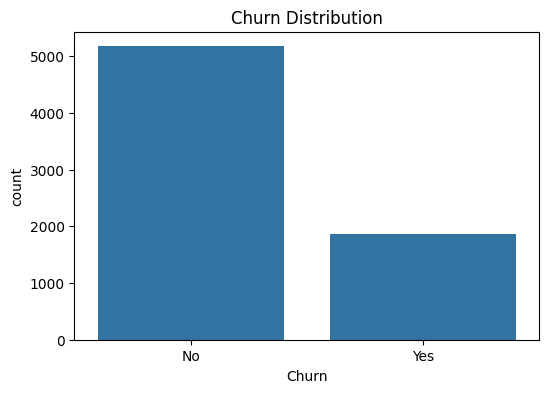

In [49]:
plt.figure(figsize=(6,4))
sns.countplot(x=customer_churn["Churn"])
#the above code snippet was generated from ChatGPT on 2/2/2025 at 10:31pm
plt.title("Churn Distribution")
plt.show()

#### Discussion

We see a lot of 0 counts, our data is imbalanced. Our modeling will see more observations when Churn does not occur, so it may be better at predicting that.

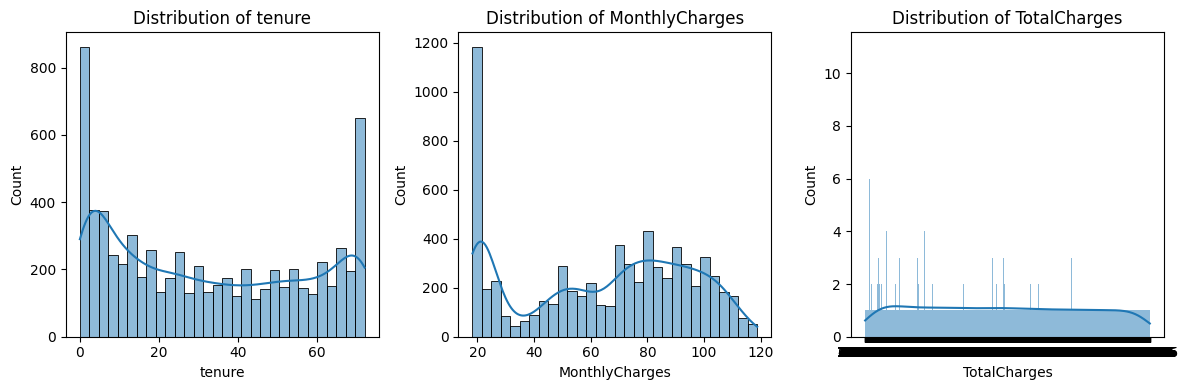

In [50]:
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

plt.figure(figsize=(12, 4))
for i, col in enumerate(num_cols):
    plt.subplot(1, 3, i + 1)
    sns.histplot(customer_churn[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

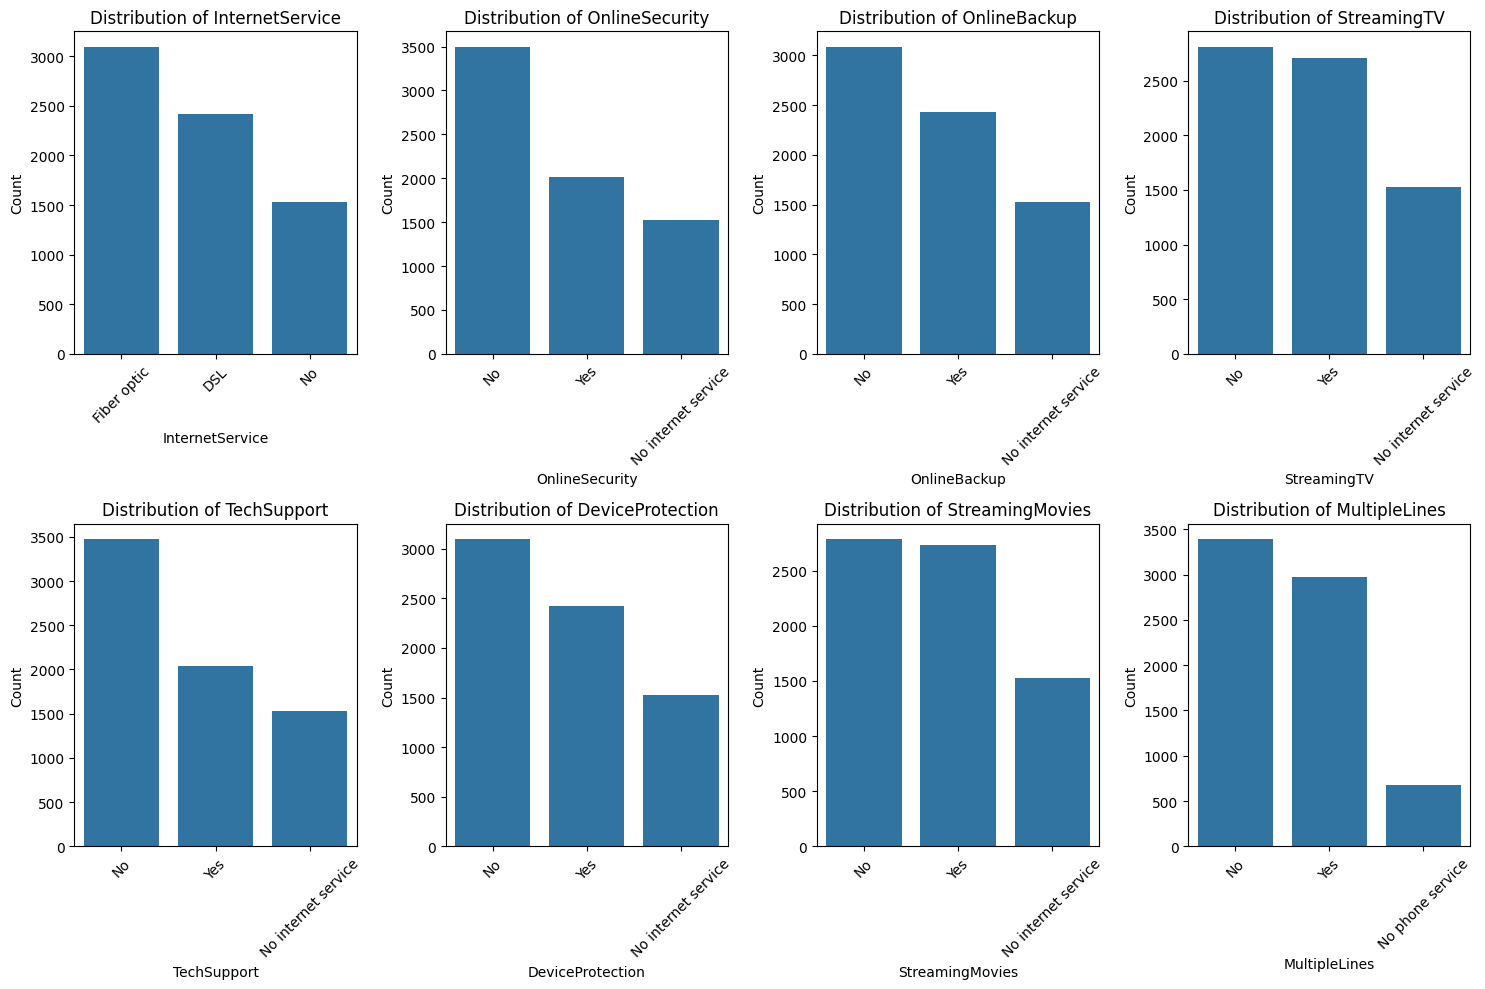

In [51]:
internet_service_columns = [
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'StreamingTV',
    'TechSupport',
    'DeviceProtection',
    'StreamingMovies',
    'MultipleLines'
]

plt.figure(figsize=(15, 10))

#plot the categorical distributions
for i, column in enumerate(internet_service_columns, 1):
    plt.subplot(2, 4, i)

    value_counts = customer_churn[column].value_counts()

    sns.barplot(x=value_counts.index, y=value_counts.values)
    #the above line of code was generated from ChatGPT on 2/2/2025 10:42pm
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

#### Discussion

The distributions for all variables are not normal. We see a lot of counts in the first bin across all 3 variables. Total charges has a lot of varying values. We will be sure to normalize these prior to modeling.

## Clean data for modeling

In [52]:
customer_churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [53]:
customer_churn.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

#### Scale and Prepare dataset.

We will convert any data types needed, scale the numerics so they are on the same scale. I also converted the categorical variables to be dummy variables.

In [54]:
# 0/1 binary
customer_churn["TotalCharges"] = pd.to_numeric(customer_churn["TotalCharges"], errors="coerce")
customer_churn["Churn"] = customer_churn["Churn"].map({"No": 0, "Yes": 1})
#drop customer numbers
customer_churn = customer_churn.drop(columns=["customerID"])
customer_churn = pd.get_dummies(customer_churn, drop_first=True)

#standarize numerics
scaler = StandardScaler()
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
customer_churn[num_cols] = scaler.fit_transform(customer_churn[num_cols])

#drop nas
customer_churn = customer_churn.dropna()


In [55]:
customer_churn.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,-1.277445,-1.160323,-0.994194,0,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0,0.066327,-0.259629,-0.173740,0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,0,-1.236724,-0.362660,-0.959649,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0,0.514251,-0.746535,-0.195248,0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,0,-1.236724,0.197365,-0.940457,1,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


### Linear Regression

In [56]:
#we treat churn as a continous
customer_churn["Churn"] = customer_churn["Churn"].astype(float)

In [57]:
#separate x and y
X = customer_churn.drop(columns=["Churn"])
y = customer_churn["Churn"]

#### Linearity assumption

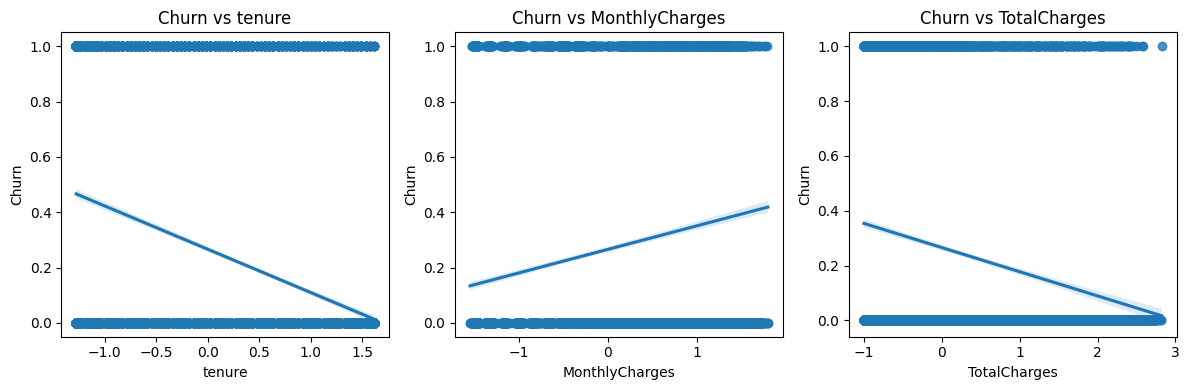

In [58]:
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

plt.figure(figsize=(12, 4))
for i, col in enumerate(num_cols):
    plt.subplot(1, 3, i + 1)
    sns.regplot(x=customer_churn[col], y=customer_churn["Churn"])
    plt.title(f"Churn vs {col}")
plt.tight_layout()
plt.show()

##### Linearity Discussion

Since "Churn" is a binary the linear regression will not be the best. However, there is some form of a linear relationship as we can see from the red lines above.

#### Multicollinearity check

In [59]:
from HW2_Functions import *

X = prepare_data_for_vif(X)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]
#The above line of code was generated on ChatGPT on 2/2/2025 at 3:04pm

# Sort and display results
print("VIF Values:")
print(vif_data.sort_values('VIF', ascending=False))

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF Values:
                                  Feature         VIF
11                     InternetService_No         inf
12     OnlineSecurity_No internet service         inf
20        StreamingTV_No internet service         inf
18        TechSupport_No internet service         inf
16   DeviceProtection_No internet service         inf
14       OnlineBackup_No internet service         inf
22    StreamingMovies_No internet service         inf
2                          MonthlyCharges  866.089640
7                        PhoneService_Yes  353.337855
10            InternetService_Fiber optic  148.500814
8          MultipleLines_No phone service  148.495347
23                    StreamingMovies_Yes   24.156394
21                        StreamingTV_Yes   24.080019
3                            TotalCharges   10.811490
1                                  tenure    7.584453
9                       MultipleLines_Yes    7.289761
17                   DeviceProtection_Yes    6.924754
15              

In [60]:
# drop the no service vars bc they are captured elsewhere
X = X.drop(columns=["MultipleLines_No phone service", "OnlineBackup_No internet service", "StreamingTV_No internet service",
                    "StreamingMovies_No internet service", "DeviceProtection_No internet service", "TechSupport_No internet service", "OnlineSecurity_No internet service"])
#the above code snippet was autofilled using Colab Gemini on 2/2/2025 1:56pm

In [61]:
#check multicollinearity again
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]
print("VIF Values:")
print(vif_data.sort_values('VIF', ascending=False))

VIF Values:
                                  Feature        VIF
2                          MonthlyCharges  17.308785
3                            TotalCharges  10.809275
7                        PhoneService_Yes  10.300233
9             InternetService_Fiber optic   7.629788
1                                  tenure   7.583851
10                     InternetService_No   6.867251
18                      Contract_Two year   3.487159
15                        StreamingTV_Yes   3.054824
16                    StreamingMovies_Yes   3.031153
21         PaymentMethod_Electronic check   2.972764
19                   PaperlessBilling_Yes   2.965242
5                             Partner_Yes   2.827071
8                       MultipleLines_Yes   2.640745
22             PaymentMethod_Mailed check   2.402600
13                   DeviceProtection_Yes   2.267015
12                       OnlineBackup_Yes   2.093282
14                        TechSupport_Yes   2.088292
17                      Contract_O

##### Multicollinearity Discussion

There was perfect collinearity between the 'no internet service' sub categories of relevant columns. This makes sense as there is a whole variable which provides the same information of "No internet service." I removed those and then the collinearity between variables gets signficantly better. Monthly charges and total charges, however, I think that having these as separate values is still important, because it provides a time interval for how long a customer was with the company.

### Normality check

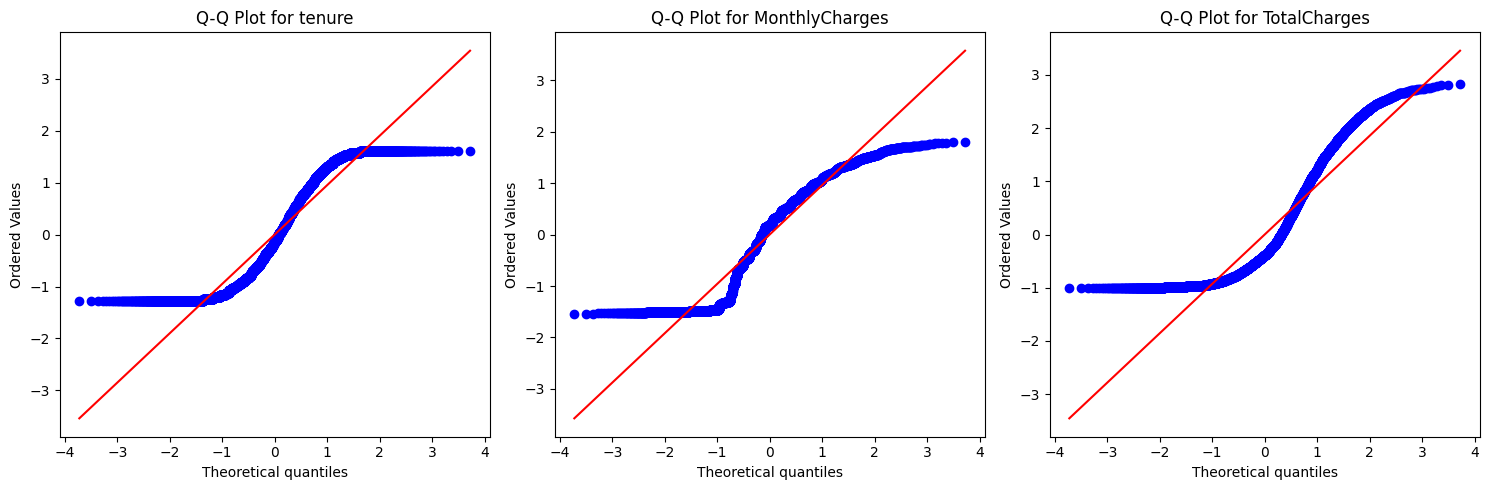

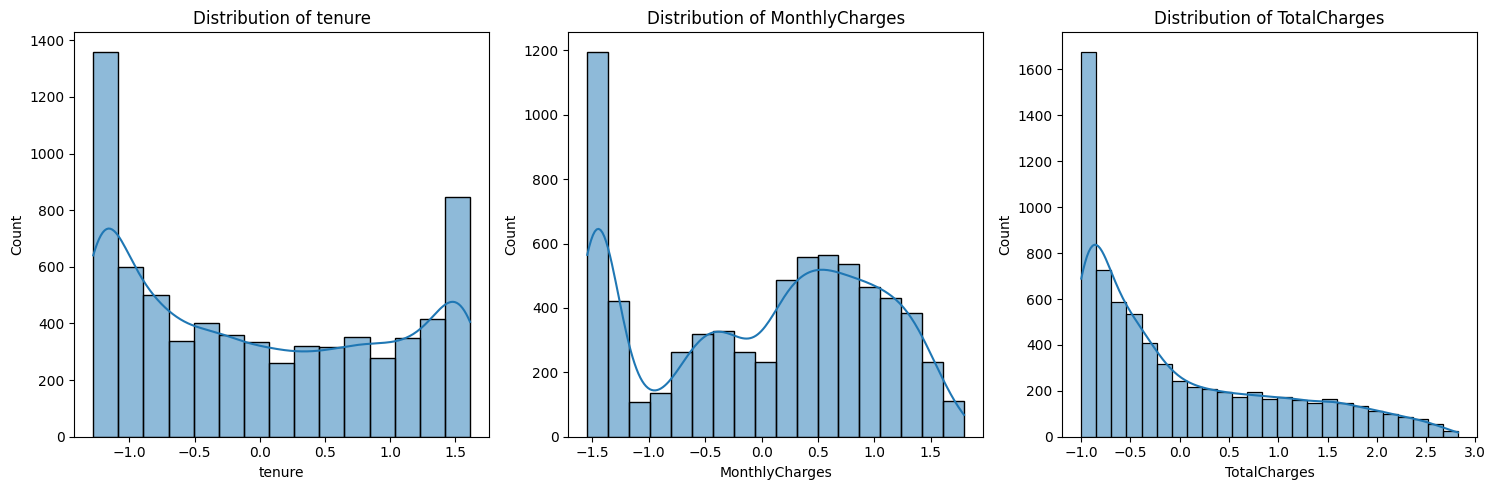

In [62]:

num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
# Q-Q Plot
plt.figure(figsize=(15,5))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 3, i)
    stats.probplot(X[col], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot for {col}')

plt.tight_layout()
plt.show()

# Histogram to check for normality
plt.figure(figsize=(15,5))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(X[col], kde=True)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

##### Normality Discussion

The normality assumption does not pass, in the QQ plot the blue line does not follow the red line, and we see skewness in the histograms. This means we should look for a transformation that could fix this. I will try using a log and sqrt transformation.

In [63]:
X[f'log_{num_cols[1]}'] = np.log1p(X[num_cols[1]])
X[f'sqrt_{num_cols[0]}'] = np.sqrt(X[num_cols[0]])

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


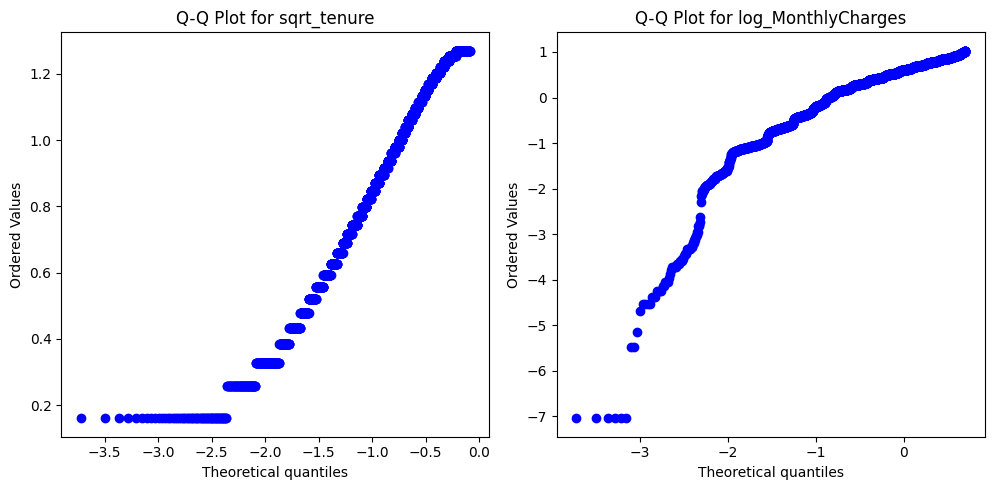

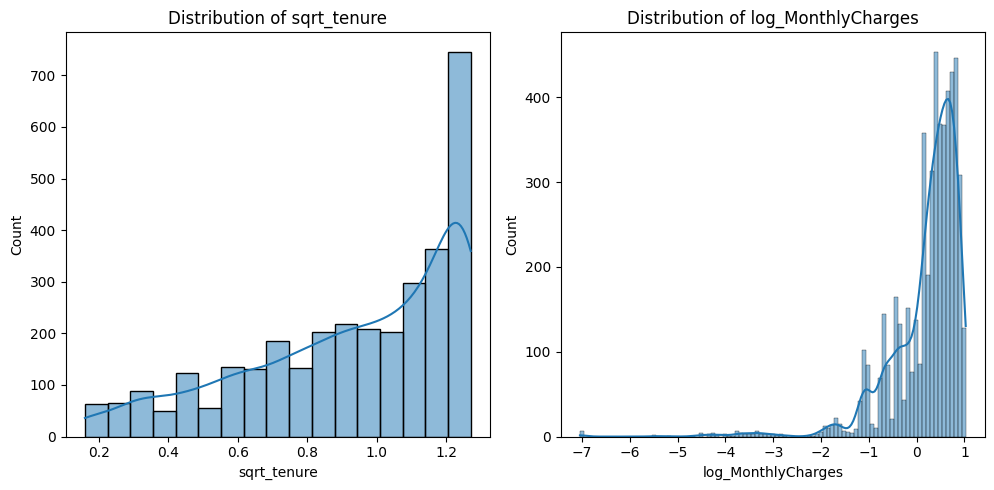

In [64]:
#look at same plots with transformations
new_num =[f'sqrt_{num_cols[0]}', f'log_{num_cols[1]}']

plt.figure(figsize=(15,5))
for i, col in enumerate(new_num, 1):
    plt.subplot(1, 3, i)
    stats.probplot(X[col], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot for {col}')

plt.tight_layout()
plt.show()
plt.figure(figsize=(15,5))
for i, col in enumerate(new_num, 1):
    plt.subplot(1, 3, i)
    sns.histplot(X[col], kde=True)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

##### Normality Discussion

The transformations were not helpful. I will just continue with the MinMax Scaler values, as the data just has wide counts at the ends (0,1) after scaling them. The variables do not pass the normality assumption.

In [65]:
#drop transformed vars
X = X.drop(columns=[f'sqrt_{num_cols[0]}', f'log_{num_cols[1]}'])

In [66]:
# linear regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Churn   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     100.1
Date:                Tue, 04 Feb 2025   Prob (F-statistic):               0.00
Time:                        02:09:22   Log-Likelihood:                -2417.5
No. Observations:                5625   AIC:                             4883.
Df Residuals:                    5601   BIC:                             5042.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

##### Model Results Discussion

The r squared is .29, or 29% of the variance is explained by the data. This is not good. There are a lot of predictors with high p-values and low coeffcient values. An example of one intrepretation is,
- For each additional unit increase in tenure, the predicted probability of churn decreases by 0.0464 (or 4.6 percentage points). I will try to improve model performance by dropping insignficant coeffcients which do not help.

In [67]:
# drop insignifcant vars
X=X.drop(columns=["gender_Male", "Partner_Yes", "OnlineBackup_Yes", "PaymentMethod_Credit card (automatic)", "PaymentMethod_Mailed check"])

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train=sm.add_constant(X_train)
X_test=sm.add_constant(X_test)
model = sm.OLS(y_train,X_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Churn   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     127.9
Date:                Tue, 04 Feb 2025   Prob (F-statistic):               0.00
Time:                        02:09:22   Log-Likelihood:                -2418.0
No. Observations:                5625   AIC:                             4874.
Df Residuals:                    5606   BIC:                             5000.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

##### Model Results Discussion

After dropping some variables, we see that the model performance does not improve. I will check the reaminaing assumptions now that we have run the model, then I will test the model. However, I have minmal faith it will perform well.

Durbin-Watson statistic: 1.997 (≈2 suggests independence)


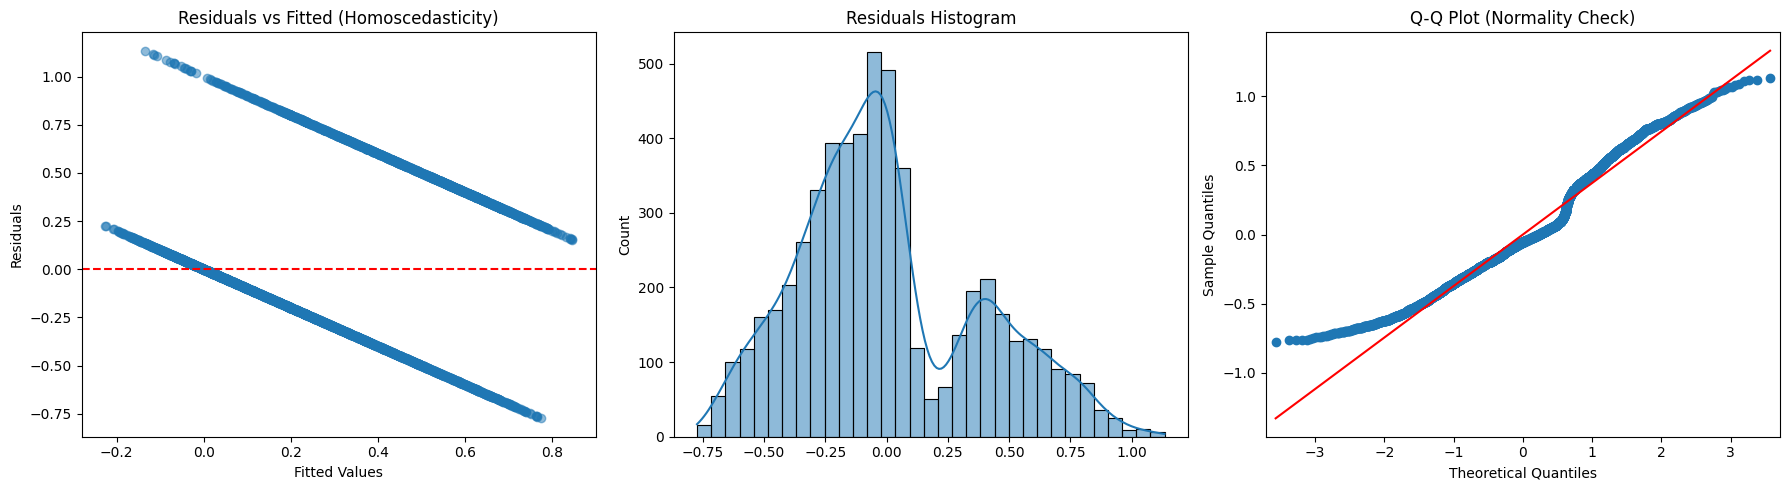

In [69]:
check_regression_assumptions(model, X_train, y_train)

##### Model Assumptions Discussion

The Homoscedasticity assumption does not pass. The residuals should show no pattern and be evenly distributed. The QQ plot is better than expected, hinting that the normality assumption could pass. The histogram of the residuals does show some distrubtion, but not normally. The durbin watson test demonstrates independence with a value close to 2.

In [70]:
test_regression_model(model, X_test, y_test)

{'MSE': 0.14577956454160385,
 'RMSE': 0.3818109015489262,
 'MAE': 0.30309430246668106,
 'R2': 0.2530132132534867}

#### Model Interpetations

The r squared value is still very low, the variability is only explained by the data 25% of the time. The RMSE and MAE indicate the predictions moderately deviate from actual values. 2 coefficient inerpretations for the new linear regression is:
- For every additional unit increase in tenure, the predicted probability of churn decreases by 4.5 percentage points, holding other variables constant.
- Customers with Fiber Optic internet have a predicted churn probability that is 24.39 percentage points higher compared to the other categories, holding other factors constant.

## Logistic Regression

In [71]:
#complete logistic regression model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [72]:
X.columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes',
       'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_One year',
       'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Electronic check'],
      dtype='object')

In [73]:
print("Classification Report:\n", classification_report(y_test, y_pred))
#This line of code was generated with ChatGPT on 2/3/2025 at 11:42am

Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.89      0.86      1033
         1.0       0.63      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.72      1407
weighted avg       0.78      0.79      0.78      1407



In [74]:
column_names = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes',
       'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_One year',
       'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Electronic check']

coeff_df = pd.DataFrame(model.coef_[0], index=column_names, columns=['Coefficient'])

coeff_df

,Coefficient
SeniorCitizen,0.266946
tenure,-1.438588
MonthlyCharges,-0.438561
TotalCharges,0.677459
Dependents_Yes,-0.195180
PhoneService_Yes,-0.322386
MultipleLines_Yes,0.298013
InternetService_Fiber optic,1.158459
InternetService_No,-1.059549
OnlineSecurity_Yes,-0.369369


#### Linearity of log-odds



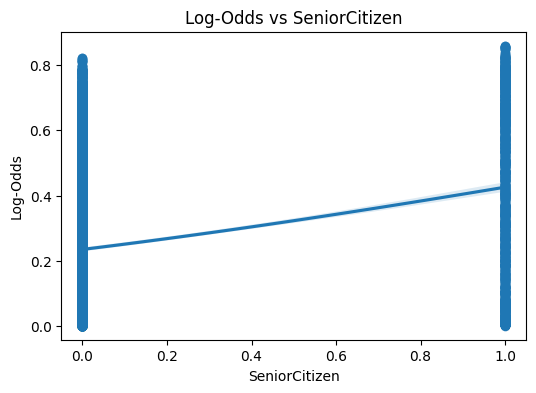

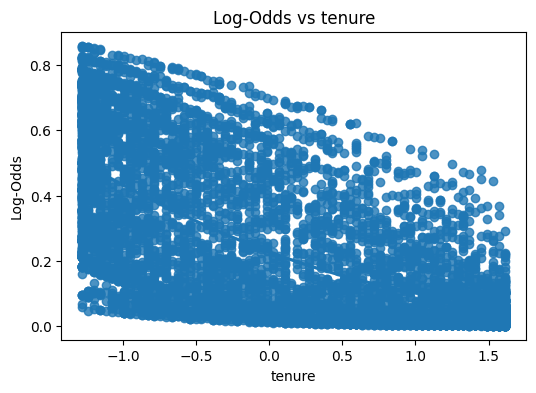

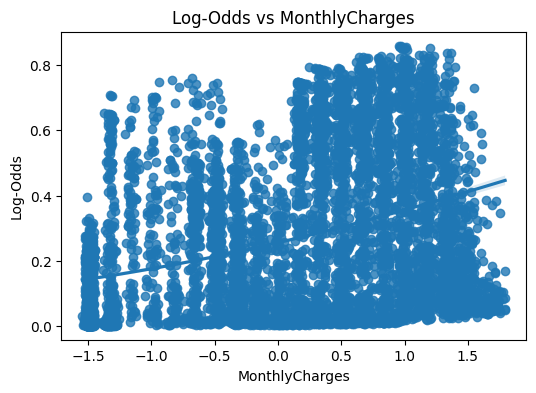

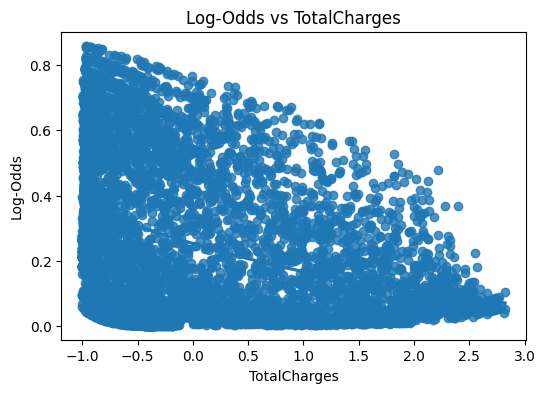

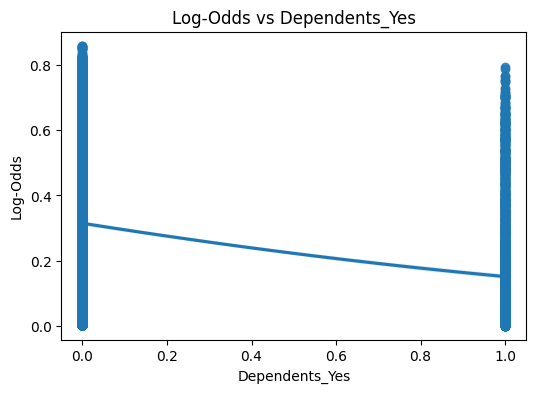

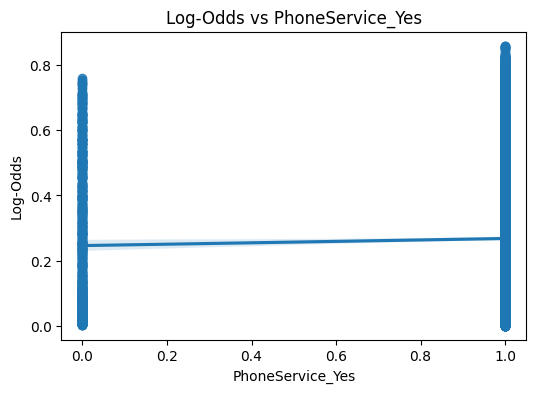

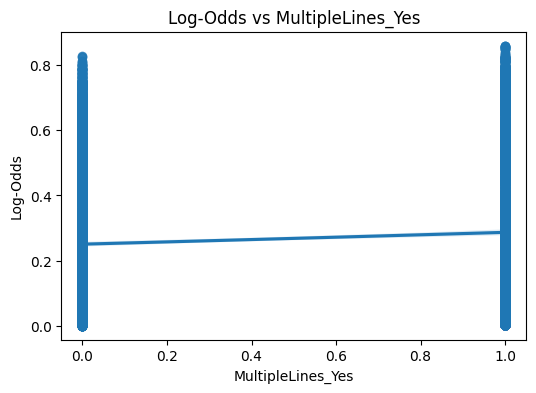

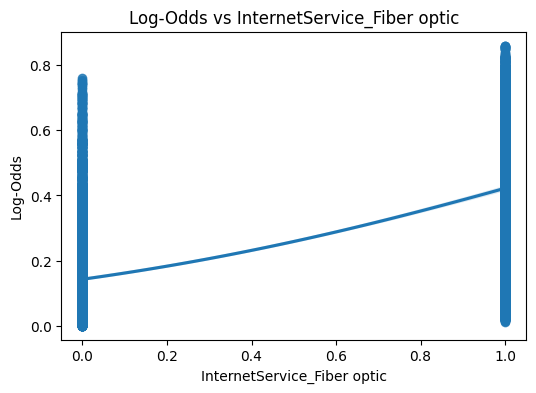

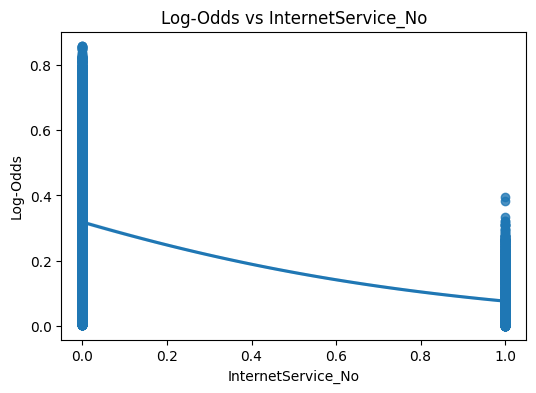

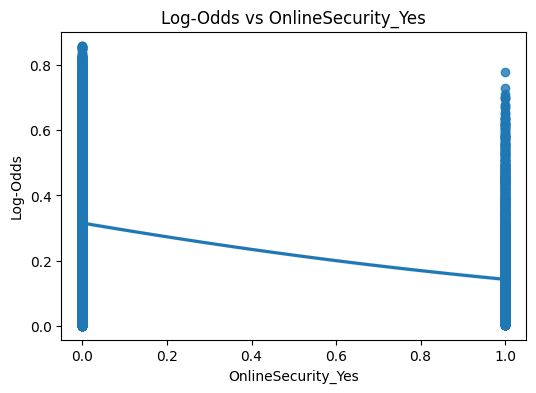

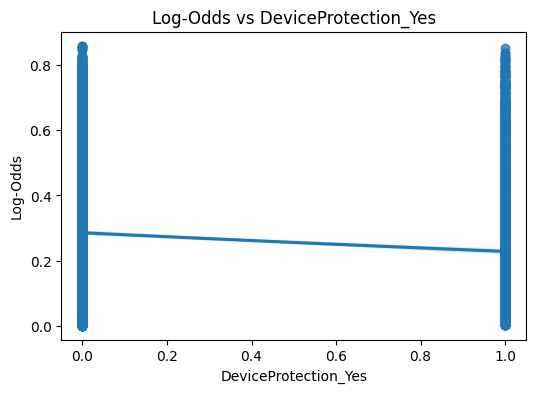

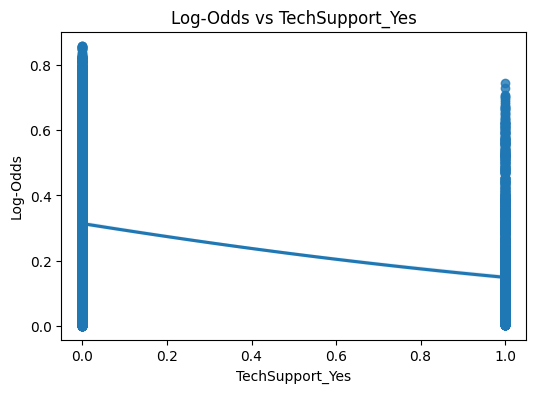

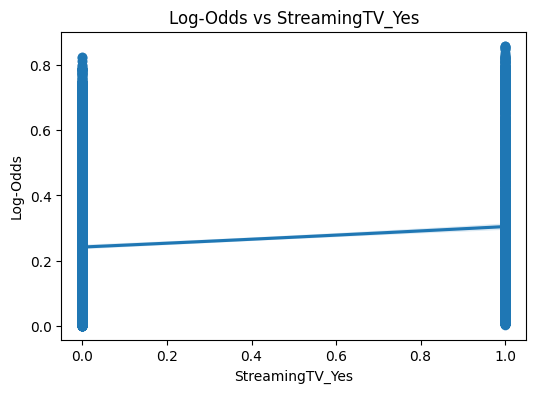

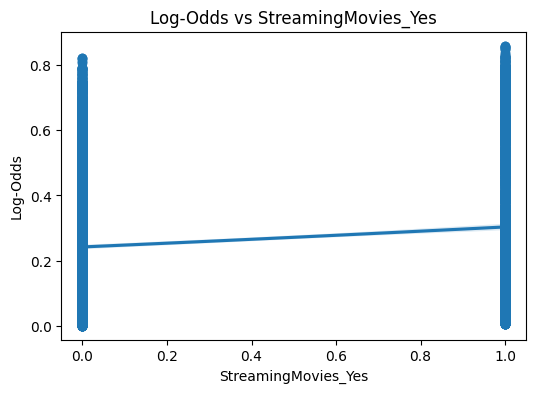

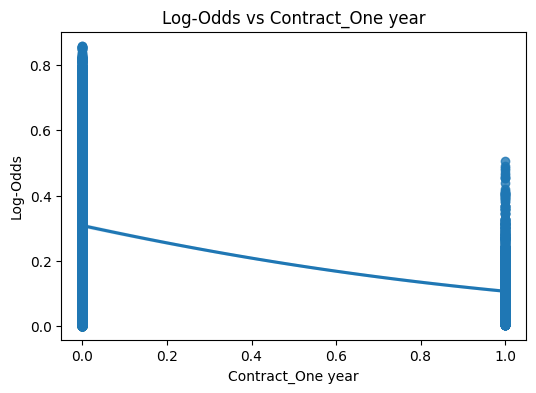

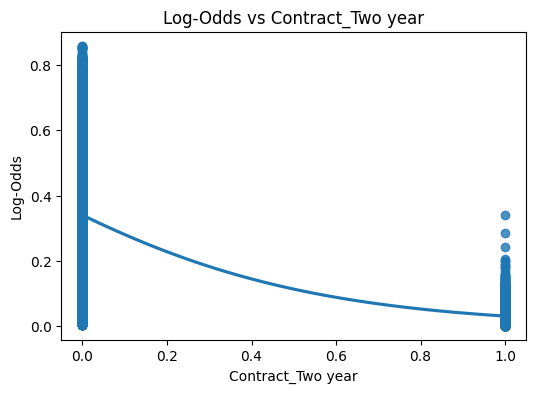

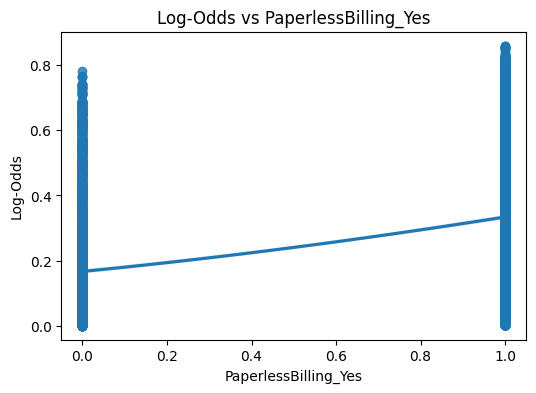

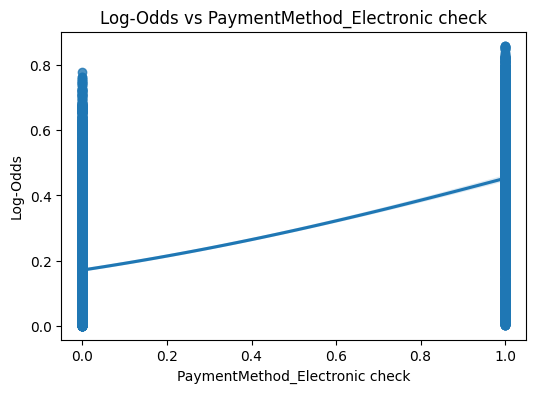

In [75]:
for feature in X.columns:
    plt.figure(figsize=(6, 4))
    sns.regplot(x=X[feature], y=model.predict_proba(X)[:, 1], logistic=True)
    #This line was generated on ChatGPT at 2/3/2025 11:48am
    plt.title(f'Log-Odds vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Log-Odds')
    plt.show()

In [76]:
y_train_pred = model.predict(X_train)

residuals = y_train - y_train_pred

dw_stat = durbin_watson(residuals)
print(f'Durbin-Watson Statistic: {dw_stat}')
print("Value means it is independent")

Durbin-Watson Statistic: 2.0064397424103038
Value means it is independent


#### Logistic regression discussion

I mantained the same variables as the linear regression so there was no multi-collinearity and variables that mattered previously to start. The predictors mostly show linearity between the log odds. There is little skewness to a few of the variables however, the accuracy is .79.

- An accuracy of 0.79 in a logistic regression model means that the model correctly predicted the outcome (either churn or no churn) 79% of the time.
- The coefficient interpretation of *tenure* is 0 for each 1 unit increase in tenure, the log-odds of the outcome decreases by 1.438588.
- The model is has high precision (0.84) and high recall (0.89) when there is NO CHURN
- The model has lower precision (0.63) and lower recall (0.52) when there is CHURN.

This confirms the data imbalance we saw at the beginning, the model sees more NO CHURN observations than CHURN.

The interpretation of coefficients is better understood is of we take the exponential and get the odds ratio. That results in an odds ratio of 0.237 means that for each additional year of tenure, the odds of churning are reduced by 76.3%

We can do similar interpretations for every coefficient.


## GAM

We ideally want to only have non linear predictors of CHURN for GAM. However, we need to mantain the same variables so that we can compare the modeling techniques.

In [77]:
X_train.dtypes

,0
SeniorCitizen,float64
tenure,float64
MonthlyCharges,float64
TotalCharges,float64
Dependents_Yes,float64
PhoneService_Yes,float64
MultipleLines_Yes,float64
InternetService_Fiber optic,float64
InternetService_No,float64
OnlineSecurity_Yes,float64


In [80]:
gam = LogisticGAM(
    s(1, n_splines=10) +
    s(2, n_splines=10) +
    s(3, n_splines=10) +
    f(0) +
    f(4) +
    f(5) +
    f(6) +
    f(7) +
    f(8) +
    f(9) +
    f(10) +
    f(11) +
    f(12) +
    f(13) +
    f(14) +
    f(15) +
    f(16) +
    f(17)
)
#Chat GPT was used to format this line of code on 2/3/2025 11:42am

In [81]:
gam.fit(X_train, y_train)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(1) + s(2) + s(3) + f(0) + f(4) + f(5) + f(6) + f(7) + f(8) + f(9) + f(10) + f(11) + f(12) + f(13) + f(14) + f(15) + f(16) + f(17) + intercept,
   tol=0.0001, verbose=False)

In [82]:
#Make predictions
y_pred = gam.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

print("Model Performance:")
print(classification_report(y_test, y_pred_binary))


Model Performance:
              precision    recall  f1-score   support

         0.0       0.83      0.90      0.87      1033
         1.0       0.65      0.49      0.56       374

    accuracy                           0.80      1407
   macro avg       0.74      0.70      0.71      1407
weighted avg       0.78      0.80      0.79      1407



In [83]:
linear_coeffs = gam.coef_[:3]  # get linear coef for interpretations
print("Linear coefficients:", linear_coeffs)

Linear coefficients: [4.80428302 1.48243971 0.14044239]


Coefficient interpretation
- For every additional unit increase in tenure, the predicted probability of churn increases by 4.8, holding other variables constant.

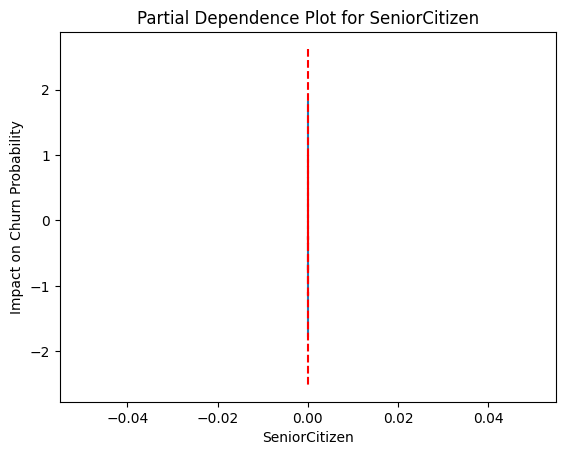

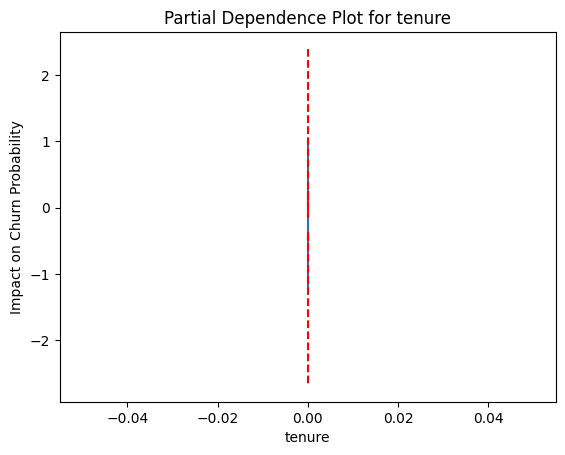

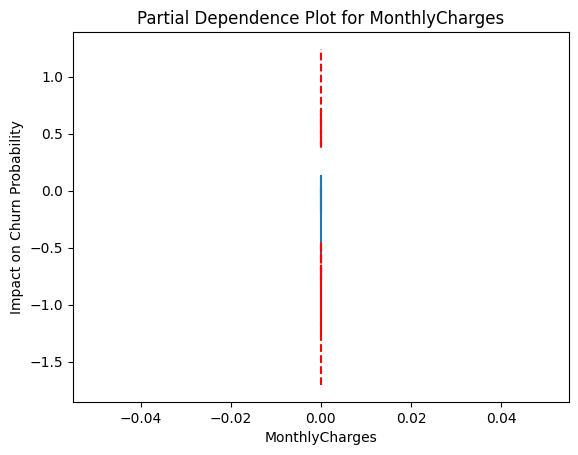

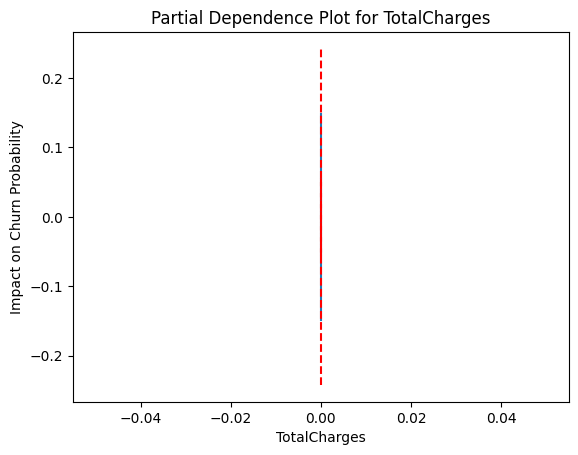

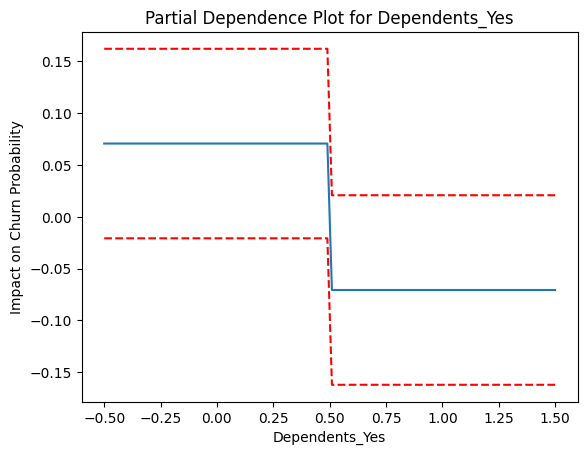

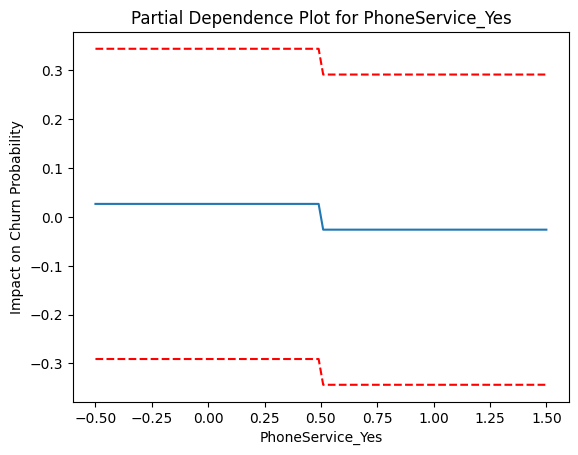

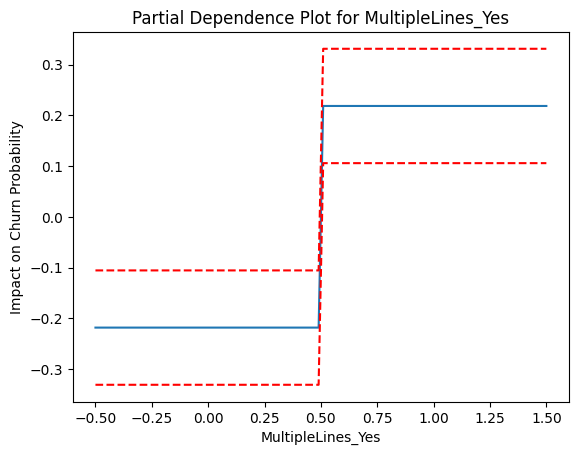

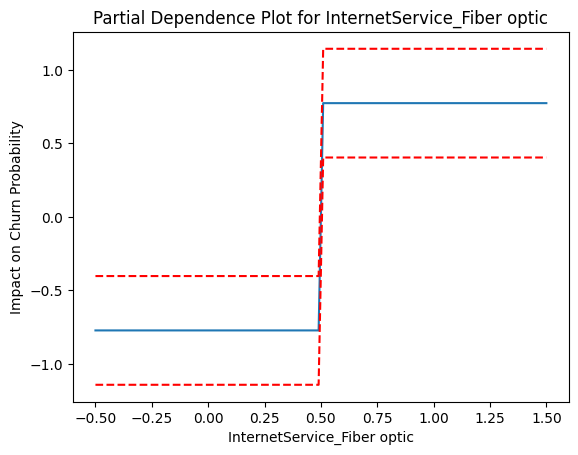

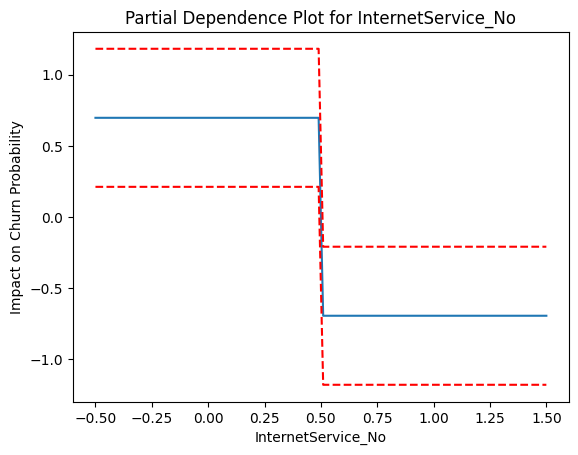

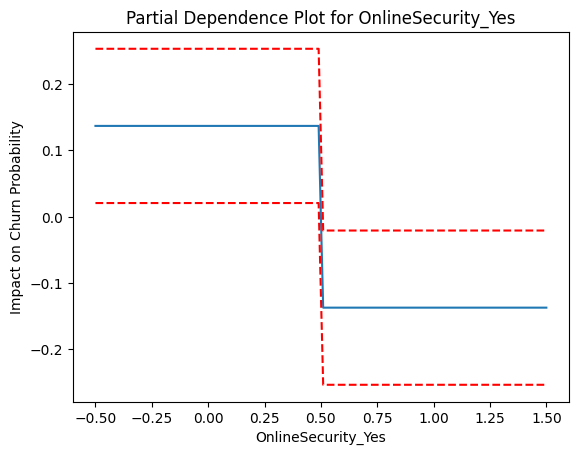

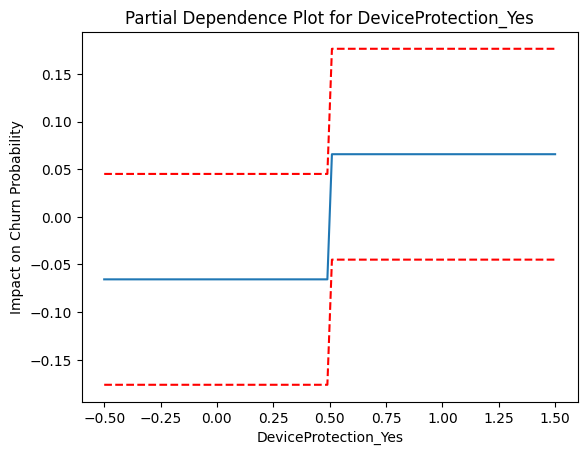

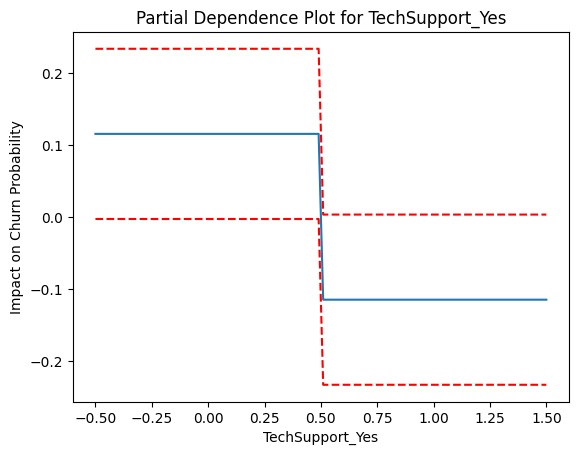

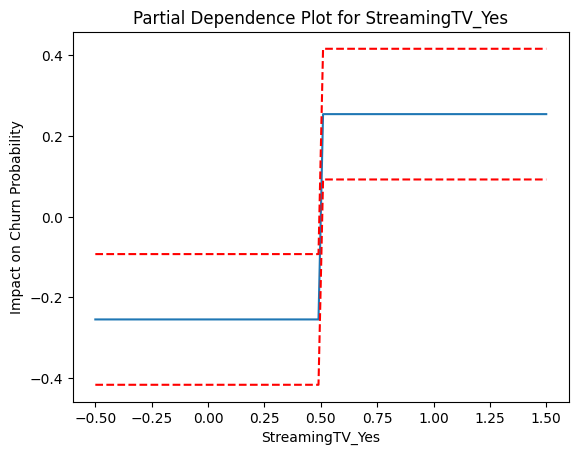

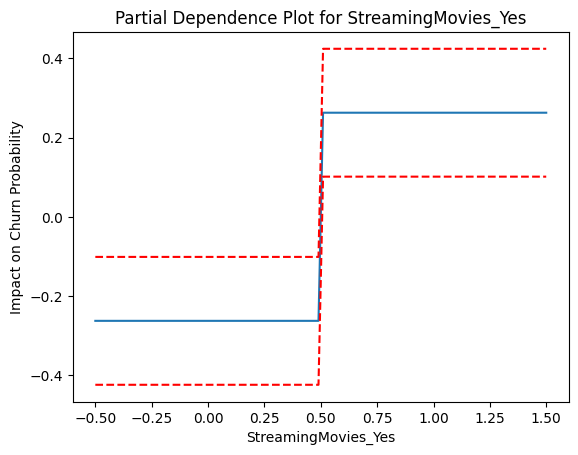

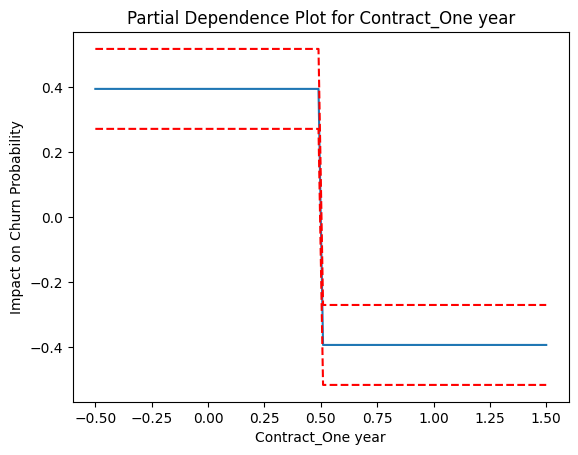

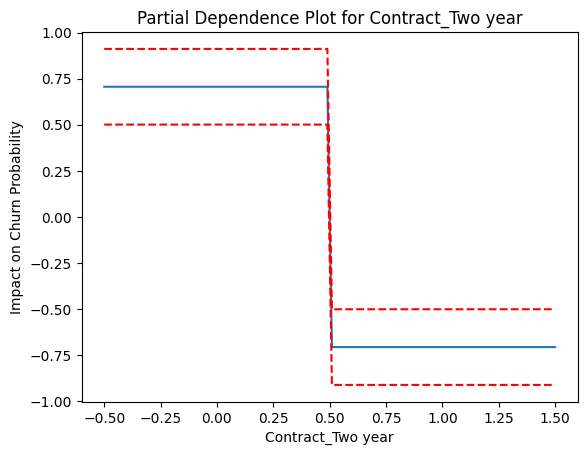

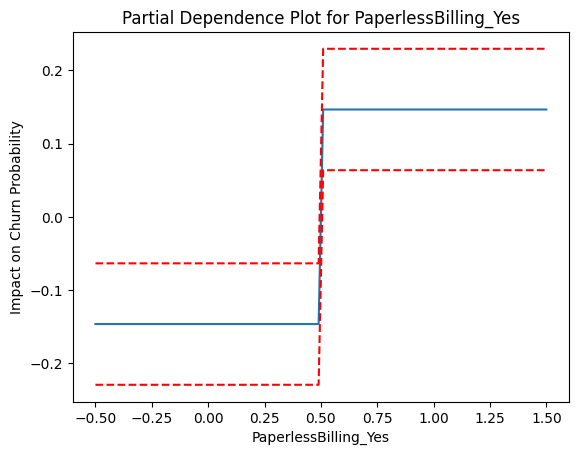

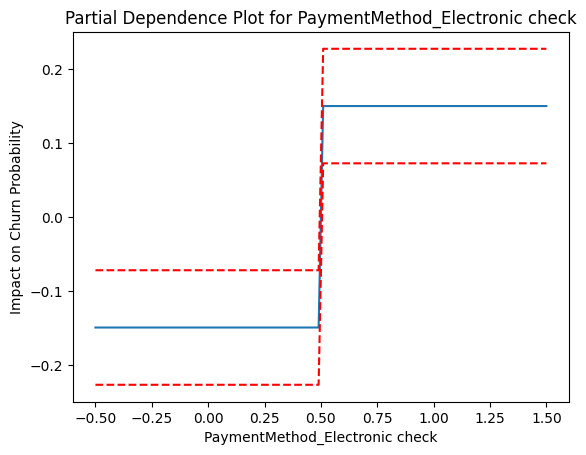

In [84]:
#get partial dependence plots
for i, feature in enumerate(X.columns):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    plt.figure()
    plt.plot(XX[:, i], pdep)
    plt.plot(XX[:, i], confi, c='r', ls='--')
    #the above 4 lines of chode were generated with ChatGPT on 2/3/2025 at 12:01pm
    plt.title(f'Partial Dependence Plot for {feature}')
    plt.xlabel(feature)
    plt.ylabel('Impact on Churn Probability')
    plt.show()

I assessed the partial dependence plots. There are some takeaways from each plot. The stepped features are ones which are categorical rather than numerical

**Here is one interpretation of a categorical variable: two year contract.**

- Customers without a two year contract (left side, x ≈ 0) show a positive impact on churn probability, meaning they are more likely to churn.
- Customers with two year contract(right side, x ≈ 1) have a lower impact on churn probability, indicating they are less likely to churn.
- The red lines are confidence intervals, indicating a range of the predictability.

**Here is the intepretation of the numerical variable: Monthly Charges**

- The x-axis is nearly collapsed to a single point (0.00), which is unexpected because MonthlyCharges should be a continuous variable.
- The confidence intervals are extremely wide, suggesting high uncertainty or an issue in the estimation.
- The vertical overlapping nature of the lines indicates that the model is struggling to capture any meaningful trend for this variable.

#### Discussion

Logistic GAM output for customers who do not churn show higher results, than those who do churn. The model correctly classifies 80% of all instances, which is a reasonable result for many tasks but doesn't account for class imbalance.

**For those that DID NOT CHURN:**

- Precision (0.83): Out of all the predictions the model made for class 0, 83% were correct.
- Recall (0.90): Of all actual class 0 instances, 90% were correctly identified by the model.

**For those that DID CHURN:**

- Precision (0.65): Out of all the predictions the model made for class 1, 65% were correct. This indicates that the model is more likely to misclassify class 1 compared to class 0.
- Recall (0.49): Of all actual class 1 instances, only 49% were correctly identified, suggesting the model struggles with identifying class 1 as compared to class 0.



## Model Comparison and Discussion

The linear regression performs the worst, with only a r squared value of .29. We should expect this however with our output being binary: churn or do not churn. The logistic regression and the gam logistic perform similarly. However, I would prefer the gam logistic since the accuracy is slightly better and it works with the non normal and non linear variables we have in the dataset. With further analysis either method would work. We would need to insure more detailed predictor analysis by just including non linear variables for GAM and linear relationships in the logistic. However, the logistic regression is easier to understand and more common for every day employees. The logistic regression would be more suitable for a non technical audience or ease of deployment and interpretaion for all employees.

#### Strengths:

- Linear regression: Simple to run and known by many people. Easy to interpret and assess.
- Logistic Regression: Simple strengths as above, but also performs well with minimal data restructuring.
- GAM: Performs the best and works with non-linear data.

#### Limitations:
- Linear regression: Very poor accuracy. Does not work well with the binary outcome variable. Does not work well with the non linear and non normal data.
- Logistic regression: Some of the predictors did not have linearity. It does not like the imbalanced churn data.
- GAM: Harder to understand, not has frequently used. The coefficents interpretablity is not as simple for all the coeffcients.

#### Formal recommendation:

If the company has many technical employees, I would recommend the GAM model. If the audience is less technical I would recommend the logistic regression. I would also recommend more in-depth predictor analysis and transformations.